In [1]:
### Set-up for training a U-net convolutional neural network for sementic segmentation ###
import os
os.chdir('E:/BasW/Notebooks') 
work_directory = os.getcwd()
os.chdir(work_directory+'/Scripts')
from DataCreation import *
from DataPreprocessing import *
from DataAugmentation import *
from DataNormalization import *
from Unet import *
from random import sample
import tensorflow
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
os.chdir('../..') # --> ensures that work directory = E:/BasW/Notebooks
work_directory = os.getcwd()
path_training_data = "E:/BasW/Data/Gras"

Using TensorFlow backend.


Set variables and directories

In [2]:
# Create processing objects
dc = N2000_Data(image_size = (256,256), cell_size = 0.25, epsg = 28992)
dp = N2000_DataPreparation(image_size = (256,256))
dn = DataNormalization(image_size = (256,256))

Create 4 dimensional images

In [25]:
#cir_path = f"{path_training_data}/Images/BGT/2016_2017_RgbCir/training_data"
#rgb_path = f"{path_training_data}/Images/BGT/2016_2017_RgbCir/training_data"
path_data = f"{path_training_data}/Images/FromVegScan/training_data"
#dc.create4dimensionalImage(path_rgb_data = rgb_path, path_cir_data = cir_path, dest_folder = path_data, name = 'h5130.tif')

Compute nomalization statistics

In [26]:
## READ DATA IN A NUMPY ARRAY ##
#cir_array = dp.ImagesToArray(img_folder = cir_path, mask = False)
#rgb_array = dp.ImagesToArray(img_folder = path_data, mask = False)
cir_rgb_array = dp.ImagesToArray(img_folder = path_data, mask = False)
#print(cir_rgb_array.shape)
print(cir_rgb_array.shape)

(2048, 256, 256, 4)


In [27]:
## CALCULATE NORMALIZATION STATISTICS ##
stats_cir_rgb = dn.CalculateNormalizationStatisticsPerBand(np_array = cir_rgb_array, csv_folder = path_data, csv_name= "2016_2017_FromVegScan_NormalizationCirRgbPerBand.csv", bands = 4)
stats_cir_rgb2 = dn.CalculateNormalizationStatistics(np_array = cir_rgb_array, csv_folder = path_data, csv_name= '2016_2017_FromVegScan_NormalizationCirRgb.csv')
#stats_rgb = dn.CalculateNormalizationStatisticsPerBand(np_array = rgb_array, csv_folder = rgb_path, csv_name= "2017_2018_Totaal_NormalizationRgbPerBand.csv", bands = 3)
#stats_rgb2 = dn.CalculateNormalizationStatistics(np_array = rgb_array, csv_folder = rgb_path, csv_name= '2017_2018_Totaal_NormalizationRgb.csv')

119.630
40.313
-2.447
3.358
124.242
36.115
-2.831
3.621
118.687
36.066
-2.903
3.780
135.976
38.626
-3.236
3.081
124.442
38.484
-2.948
3.393
11.000
255.000


In [29]:
### SAVE FOLDER OF IMAGES AS H5 FILE WITH FILENAMES ###
path_data = f"{path_training_data}/Images/FromVegScan/training_data"
dp.SaveTrainingData(path_data, '2016_2017_FromVegScan_CirRgb.h5')

Load and preprocess data

- Devide image data in training- validation and test set
- Perform data augmentation on training- and validation ses

In [30]:
# RUN FUNCTIONS VERSION 1: ONE H5 Files # 
folder = path_training_data+"/training/Run6"
h5Path = path_training_data + "/training/Run6/2016_2017_FromVegScan_CirRgb.h5"
x_train, y_train, x_val, y_val, x_test, y_test, filenamesTest = dp.DevideData(path_dataset = h5Path, csv_folder = folder, test_size=0, validation_size=0.25) 

# Create N2000_DataAugmentation object 
# Data augmentation on training dataset
da = N2000_DataAugmentation(x_train, y_train)
x_train_hf, y_train_hf = da.HorizontalFlip(batch_size = 150)
x_train_vf, y_train_vf = da.VerticalFlip(batch_size = 150)
x_train_rr, y_train_rr = da.RandomRotation(batch_size =600)
# Data augmentation on validation set
da2 = N2000_DataAugmentation(x_val, y_val)
x_val_hf, y_val_hf = da2.HorizontalFlip(batch_size = 40)
x_val_vf, y_val_vf = da2.VerticalFlip(batch_size = 40)
x_val_rr, y_val_rr = da2.RandomRotation(batch_size =120)

# Merge original training data with data augmentation
x_train_total = np.concatenate([x_train,x_train_hf, x_train_vf, x_train_rr])
y_train_total = np.concatenate([y_train,y_train_hf, y_train_vf, y_train_rr])
x_val_total = np.concatenate([x_val,x_val_hf, x_val_vf, x_val_rr])
y_val_total = np.concatenate([y_val,y_val_hf, y_val_vf, y_val_rr])
print(x_train_total.shape, y_train_total.shape)
print(x_val_total.shape, y_val_total.shape)

(2436, 256, 256, 4) (2436, 256, 256, 1)
(712, 256, 256, 4) (712, 256, 256, 1)


In [4]:
# RUN FUNCTIONS VERSION 2: TWO H5 Files (OPTIONAL) #
# DATA AUGMENTATION OF MANUAL ADDITIONS #
folder = path_training_data+"/training/Run5"
h5Path = path_training_data + "/training/Run5/2016_2017_Manueel_RgbNirNdviHeight.h5"
h5Path2 = path_training_data + "/training/Run5/2016_2017_BGT_RgbNirNdviHeight.h5"
x_train, y_train, x_val, y_val, x_test, y_test, filenamesTest = dp.DevideData(path_dataset = h5Path, csv_folder = folder, test_size=0, validation_size=0.25) 
x_train2, y_train2, x_val2, y_val2, x_test2, y_test2, filenamesTest2 = dp.DevideData(path_dataset = h5Path2, csv_folder = folder, test_size=0, validation_size=0.25) 

# Create N2000_DataAugmentation object 
# Data augmentation on training dataset
da = N2000_DataAugmentation(x_train, y_train)
x_train_hf, y_train_hf = da.HorizontalFlip(batch_size = 150)
x_train_vf, y_train_vf = da.VerticalFlip(batch_size = 150)
x_train_rr, y_train_rr = da.RandomRotation(batch_size =600)
# Data augmentation on validation set
da2 = N2000_DataAugmentation(x_val, y_val)
x_val_hf, y_val_hf = da2.HorizontalFlip(batch_size = 40)
x_val_vf, y_val_vf = da2.VerticalFlip(batch_size = 40)
x_val_rr, y_val_rr = da2.RandomRotation(batch_size =120)

# Merge original training data with data augmentation
x_train_total = np.concatenate([x_train,x_train_hf, x_train_vf, x_train_rr, x_train2])
y_train_total = np.concatenate([y_train,y_train_hf, y_train_vf, y_train_rr, y_train2])
x_val_total = np.concatenate([x_val,x_val_hf, x_val_vf, x_val_rr, x_val2])
y_val_total = np.concatenate([y_val,y_val_hf, y_val_vf, y_val_rr, y_val2])
print(x_train_total.shape, y_train_total.shape)
print(x_val_total.shape, y_val_total.shape)

(1709, 256, 256, 6) (1709, 256, 256, 1)
(470, 256, 256, 6) (470, 256, 256, 1)


Save training and validation dataset as separate H5-file

In [31]:
filenames = []
for i in range(len(x_train_total)):
    filename = f"{i}_trainImage"
    filenames.append(filename)
filenames_val = []
for i in range(len(x_val_total)):
    filename = f"{i}_validationImage"
    filenames_val.append(filename)
filenames_val = [n.encode("ascii", "ignore") for n in filenames_val]
filenames = [n.encode("ascii", "ignore") for n in filenames]
print(len(filenames), len(filenames_val))
# Write training dataset en validation dataset to h5-file
dp.writeH5file(images = x_train_total, masks = y_train_total, filenames = filenames, dest_h5_file = path_training_data+"/training/Run6/2016_2017_FromVegScan_CirRgb_Training_Run6.h5")
dp.writeH5file(images = x_val_total, masks = y_val_total, filenames = filenames_val, dest_h5_file = path_training_data+"/training/Run6/2016_2017_FromVegScan_Validation_Run6.h5")

2436 712


Load and normalize the data before training

Load and normalize the data before training

In [32]:
stats = path_training_data+"/training/Run6/2016_2017_FromVegScan_NormalizationCirRgbPerBand.csv"
h5_train = path_training_data+"/training/Run6/2016_2017_FromVegScan_CirRgb_Training_Run6.h5"
h5_val = path_training_data+"/training/Run6/2016_2017_FromVegScan_Validation_Run6.h5"
x_train_total, y_train_total, filenames = dp.loadH5file(h5_train)
x_val_total, y_val_total, filenames = dp.loadH5file(h5_val)
x_train_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_train)
x_val_total = dn.NormalizeDataPerBand(stats_file = stats, h5_file = h5_val)
print(x_train_total.shape, y_train_total.shape)
print(np.max(x_train_total), np.min(x_train_total), np.max(y_train_total), np.min(y_train_total))
print(x_val_total.shape, y_val_total.shape)
print(np.max(x_val_total), np.min(x_val_total), np.max(y_val_total), np.min(y_val_total)) 

119.63
124.242
118.687
135.976
119.63
124.242
118.687
135.976
(2436, 256, 256, 4) (2436, 256, 256, 1)
1.0000709 -0.094416745 1.0 0.0
(712, 256, 256, 4) (712, 256, 256, 1)
1.0000709 -0.094416745 1.0 0.0


In [33]:
# Initialize Unet model
folder_checkpoints = "E:/BasW/Data/Gras/checkpoints"
model = unet(input_size = (256, 256, 4), lr=0.00001, drop_out = 0.1)
#model.load_weights(filepath = folder_checkpoints + "/gras_bgt_Weights_run9.h5")

In [34]:
# Checkpoints
folder_checkpoints = "E:/BasW/Data/Gras/checkpoints"
checkpoint1 = ModelCheckpoint((folder_checkpoints + '/Run6_weights_best.h5'), monitor='val_acc', verbose = 1, save_best_only=True, mode = "max", period = 1)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 4)
# Tensorboard
tensorboard = TensorBoard(log_dir= folder_checkpoints + '/tensorboard/Run6/', write_graph=True, write_images=True)
# Reduce learning rate on plateu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0000001)

# CSV Logger
csv_logger = CSVLogger(folder_checkpoints + '/Run6_trainingHistory.csv', append = True, separator = ',')

calbacks_list = [checkpoint1, es, tensorboard, csv_logger, reduce_lr]

# Model training
history =  model.fit(x_train_total, y_train_total, validation_data = (x_val_total, y_val_total), batch_size=32, epochs=45, verbose=2, shuffle=True, callbacks=calbacks_list)

Train on 2436 samples, validate on 712 samples
Epoch 1/45
 - 58s - loss: 0.4637 - acc: 0.7255 - val_loss: 0.3825 - val_acc: 0.7229

Epoch 00001: val_acc improved from -inf to 0.72287, saving model to E:/BasW/Data/Gras/checkpoints/Run6_weights_best.h5
Epoch 2/45
 - 55s - loss: 0.3610 - acc: 0.8098 - val_loss: 0.3556 - val_acc: 0.8150

Epoch 00002: val_acc improved from 0.72287 to 0.81504, saving model to E:/BasW/Data/Gras/checkpoints/Run6_weights_best.h5
Epoch 3/45
 - 55s - loss: 0.3392 - acc: 0.8208 - val_loss: 0.3380 - val_acc: 0.8220

Epoch 00003: val_acc improved from 0.81504 to 0.82200, saving model to E:/BasW/Data/Gras/checkpoints/Run6_weights_best.h5
Epoch 4/45
 - 55s - loss: 0.3281 - acc: 0.8236 - val_loss: 0.3314 - val_acc: 0.8255

Epoch 00004: val_acc improved from 0.82200 to 0.82549, saving model to E:/BasW/Data/Gras/checkpoints/Run6_weights_best.h5
Epoch 5/45
 - 55s - loss: 0.3220 - acc: 0.8254 - val_loss: 0.3254 - val_acc: 0.8278

Epoch 00005: val_acc improved from 0.82549 

In [35]:
import pickle
with open(folder_checkpoints + '/Run6_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/gras_run6.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json")

model.save_weights(folder_checkpoints + "/gras_Weights_run6.h5")
print("Saved model to disk")

from keras import backend as K
K.clear_session()

Saved model to json
Saved model to disk


In [29]:
import pickle
with open(folder_checkpoints + '/Run2_trainHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# import json
# with open('file.json', 'w') as f:
#     json.dump(history.history, f)

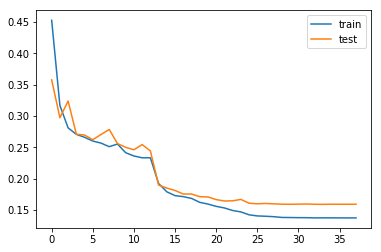

In [30]:
from matplotlib import pyplot
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

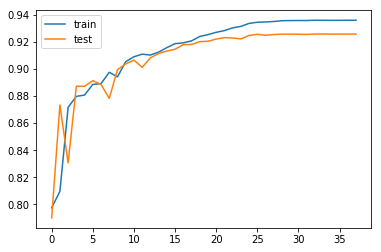

In [31]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
#_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

NameError: name 'x_test' is not defined

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open(folder_checkpoints + "/JsonModels/VegScanModel_run8.json", "w") as json_file:
    json_file.write(model_json)

In [33]:
model.save_weights(folder_checkpoints + "/VegScanModelWeights_run8.h5")
print("Saved model to disk")

Saved model to disk


In [34]:
# Clear session after training model (GPU Memory usage)
from keras import backend as K
K.clear_session()